In [1]:
%pylab inline
import pandas as pd
import sys
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
scipy.__version__

'0.19.1'

In [3]:
import numpy as np
from numba import jit 
from sklearn.metrics import mean_squared_error, r2_score
@jit
def qwk(a1, a2, max_rat=20):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / float(a1.shape[0])

    return 1 - o / e


def clip_pred(pred):
    pred=np.round(pred)
    pred[pred<0]=0
    pred[pred>20]=20
    return pred.astype(np.int8)

def qwk_score(y_true,y_pred):
    #print "RMSE", np.sqrt(mean_squared_error(y_true,y_pred))
    ypred=clip_pred(y_pred)
    return qwk(y_true,ypred)
    

In [4]:
import fastparquet
%time df=fastparquet.ParquetFile("../../input/lr_train_num_combined_latest_target_v2.parq").to_pandas()

CPU times: user 3.62 s, sys: 1.52 s, total: 5.14 s
Wall time: 5.14 s


In [5]:
df=df.loc[np.random.permutation(df.index)]
X=df.drop(['target','fold'],axis=1)
y=df['target']
trainx=X[y>=0]
trainy=y[y>=0]
testx=X[y<0]
folds=df[y>=0]['fold']
print trainx.shape,testx.shape,trainy.shape, len(folds),set(trainy)

(5203955, 50) (1378521, 50) (5203955,) 5203955 set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20])


In [6]:
gc.collect()

9960

# cv

In [7]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [8]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.intra_op_parallelism_threads=8
config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

In [9]:
input_dim=X.shape[1]
input_dim

50

In [10]:
def categorical_mean_squared_error(y_true, y_pred):
    a_true=K.sum(y_true*K_CONST,-1)
    a_pred=K.sum(y_pred*K_CONST,-1)
    return K.mean(K.square(a_true-a_pred), axis=-1)

In [11]:
y.mean(),y.std(),K.floatx()

(3.4223003623560495, 3.4872334485676895, 'float32')

In [12]:
def cqwk_error(y_true, y_pred):
    M=K.constant(4.593761,dtype=tf.float32)
    y_true_zeromean=y_true-M
    y_pred_zeromean=y_pred-M
    covab=tf.reduce_mean(y_pred_zeromean*y_true_zeromean)
    vara=tf.reduce_mean(y_true_zeromean*y_true_zeromean)
    varb=tf.reduce_mean(y_pred_zeromean*y_pred_zeromean)
    return K.constant(-2,dtype=tf.float32)*covab/(vara+varb)
def epsilon_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon))
def epsilon_squared_loss(y_true,y_pred,epsilon):
     return tf.reduce_mean(tf.maximum(0., tf.abs(y_pred-y_true)-epsilon)**2)

In [13]:
import uuid
class KerasModel:
    def __init__(self,X_train,y_train,X_valid,y_valid, params={}):
        #valid_idx=X_valid.index
        self.validation_data=(X_valid.values,y_valid.values)
        self.X_train,self.y_train=X_train.values,y_train.values
        self.name=str(uuid.uuid4())
        self.params=params
        self.this_loss=None
        print self.name,self.params
        self.model=None
    def _make_model(self):
        params=self.params
        model = Sequential()
        model.add(InputLayer(input_shape=params['input_dim']))
        if 'use_kernel' in params  and params['use_kernel']:
            model.add(KernelLayer(params['components'],params["normalization"],params['kernel'],
                                  params['gamma'],params['degree']))
        for sz in params["hidden_layer_sizes"]:
            if params['batch_normalization']:
                model.add(BatchNormalization())
            model.add(Dense(sz,kernel_regularizer=regularizers.l2(params['l2'])))
            model.add(Dropout(params['dropout_rate']))            
            model.add(Activation(params['activation']))
        if params['loss'] == 'mean_squared_error':
            model.add(Dense(1,activation=None))
            this_loss='mean_squared_error'
            if params['metric']=="mean_squared_error":
                this_metrics=[metrics.mean_squared_error]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'cqwk_error':
            model.add(Dense(1,activation=None))
            this_loss=cqwk_error
            if params['metric']=="cqwk_error":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_loss(u,v,epsilon)
            self.this_loss=this_loss
            if params['metric']=="epsilon_loss":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif params['loss'] == 'epsilon_squared_loss':
            epsilon = K.constant([params['epsilon']])
            model.add(Dense(1,activation=None))
            def this_loss(u,v):
                return epsilon_squared_loss(u,v,epsilon)
            self.this_loss=this_loss            
            if params['metric']=="epsilon_squared_loss":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_crossentropy':            
            model.add(Dense(21, activation='softmax'))
            this_loss='categorical_crossentropy'
            if params['metric']=="categorical_crossentropy":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")
        elif  params['loss'] ==  'categorical_mse':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: categorical_mean_squared_error(u,v)
            if params['metric']=="categorical_mse":
                this_metrics=[categorical_mean_squared_error]
            else:
                raise Exception("unknown")                
        elif  params['loss'] ==  'categorical_mix':            
            model.add(Dense(21, activation='softmax'))
            this_loss=lambda u,v: 0.5*categorical_mean_squared_error(u,v)+losses.categorical_crossentropy(u,v)
            if params['metric']=="categorical_mix":
                this_metrics=[this_loss]
            else:
                raise Exception("unknown")                
                
        else:
            raise Exception("unknown")
        model.compile(optimizer=params['optimizer'],
          loss=this_loss,
          metrics=this_metrics)

        self.model=model
        return self
    def fit(self,epochs=200):
        params=self.params
        patience=params['patience']
        if params['loss'] ==  'categorical_crossentropy'        :
            y=keras.utils.to_categorical(y, num_classes=21)
        if self.model is None:
            self._make_model()
        metric_name=self.model.metrics_names[-1]
        print "earlystopping on "+metric_name
        early_stopping = EarlyStopping(monitor='val_'+metric_name, patience=patience)
        checkpoint = keras.callbacks.ModelCheckpoint(self.name, monitor='val_loss', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     save_weights_only=False, mode='auto', period=1)

        batch_size=params['batch_size']
        history=self.model.fit(self.X_train, self.y_train, batch_size=batch_size,epochs=epochs, validation_data=self.validation_data, 
                       callbacks=[early_stopping,checkpoint],verbose=1)
        return history
    def load_best(self):
        return keras.models.load_model(self.name,custom_objects={'cqwk_error':cqwk_error, 'this_loss':self.this_loss})

In [14]:
def make_tf_kernel(X,compoents, normalization, kernel='rbf',gamma=0.1,degree=3):
    components=K.constant(compoents,dtype=tf.float32)
    normalization=K.constant(normalization.T,dtype=tf.float32)
    if kernel=='rbf':
        X=K.expand_dims(X,axis=1)
        def f(x):
            d=x-compoents
            return K.exp(-gamma*K.sum((d**2),axis=1))
        embeded=K.map_fn(f,X,dtype=tf.float32)
        return tf.matmul(embeded,normalization)
    elif kernel=='polynomial':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.pow(gamma*xy+1,degree)
        embeded=f()
        return tf.matmul(embeded,normalization)
    elif kernel=='sigmoid':
        def f():
            xy=tf.matmul(X,tf.transpose(compoents))
            return tf.tanh(gamma*xy+1)
        embeded=f()
        return tf.matmul(embeded,normalization)    
    else:
        raise Exception("unknown")        

        
class KernelLayer(Layer):

    def __init__(self, components, normalization, kernel='rbf',gamma=0.1,degree=3,  **kwargs):
        assert kernel in ['rbf','sigmoid','polynomial']
        self.components=components
        self.n_components=components.shape[0]
        self.normalization=normalization        
        self.kernel=kernel
        self.gamma=gamma
        self.degree=degree
        super(KernelLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(KernelLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return make_tf_kernel(x,self.components,self.normalization,kernel=self.kernel,gamma=self.gamma,degree=self.degree)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)   

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [16]:
def make_model(i, X_train,y_train,X_valid,y_valid, parameter):
    backend.clear_session()
    set_session(tf.Session(config=config))
    K_CONST=K.constant(np.array([range(21)]),dtype=tf.float32)
    a=KerasModel(X_train,y_train,X_valid,y_valid,parameter)
    a._make_model()
    h=a.fit()
    return a.load_best()


In [17]:
def train_once(fold):
    print fold
    X_train=trainx[(folds<>fold)]
    y_train=trainy[(folds<>fold)]
    X_valid=trainx[(folds==fold)]
    y_valid=trainy[(folds==fold)]

    regr = make_model(0, X_train,y_train,X_valid,y_valid, param)
    a= pd.DataFrame(regr.predict(testx.values),index=testx.index) 
    b=pd.DataFrame(regr.predict(X_valid.values),index=X_valid.index) 
    return a,b

def train():
    lst_valid=[]
    lst_test=[]
    for i in range(5):
        a,b=train_once(i)
        lst_test.append(a)
        lst_valid.append(b)
    return lst_valid,lst_test

In [19]:
param={'activation': 'relu',
 'batch_normalization': False,
 'batch_size': 512,
 'dropout_rate': 0.0,
 'hidden_layer_sizes': (512, 512, 512),
 'input_dim': (50,),
 'l2': 0,
 'loss': 'epsilon_squared_loss',
 'metric': 'epsilon_squared_loss',
 'optimizer': 'adam',
 'epsilon':0.25,
 'patience': 5}

In [20]:
lst_valid,lst_test=train()

0
8ecab12b-ad41-4edd-8b39-373577684d43 {'dropout_rate': 0.0, 'optimizer': 'adam', 'epsilon': 0.25, 'activation': 'relu', 'batch_size': 512, 'patience': 5, 'loss': 'epsilon_squared_loss', 'hidden_layer_sizes': (512, 512, 512), 'batch_normalization': False, 'l2': 0, 'input_dim': (50,), 'metric': 'epsilon_squared_loss'}
earlystopping on this_loss
Train on 4163591 samples, validate on 1040364 samples
Epoch 1/200
4163591/4163591 [==============================] - 66s 16us/step - loss: 3.0347 - this_loss: 3.0347 - val_loss: 2.9897 - val_this_loss: 2.9897
Epoch 2/200
4163591/4163591 [==============================] - 64s 15us/step - loss: 2.9685 - this_loss: 2.9685 - val_loss: 2.9907 - val_this_loss: 2.9907
Epoch 3/200
4163591/4163591 [==============================] - 60s 14us/step - loss: 2.9579 - this_loss: 2.9579 - val_loss: 2.9708 - val_this_loss: 2.9708
Epoch 4/200
4163591/4163591 [==============================] - 60s 14us/step - loss: 2.9504 - this_loss: 2.9504 - val_loss: 2.9842 - va

Epoch 3/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9582 - this_loss: 2.9582 - val_loss: 2.9620 - val_this_loss: 2.9620
Epoch 4/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9505 - this_loss: 2.9505 - val_loss: 2.9583 - val_this_loss: 2.9583
Epoch 5/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9449 - this_loss: 2.9449 - val_loss: 2.9784 - val_this_loss: 2.9784
Epoch 6/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9413 - this_loss: 2.9413 - val_loss: 2.9636 - val_this_loss: 2.9636
Epoch 7/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9374 - this_loss: 2.9374 - val_loss: 2.9568 - val_this_loss: 2.9568
Epoch 8/200
4163358/4163358 [==============================] - 58s 14us/step - loss: 2.9352 - this_loss: 2.9352 - val_loss: 2.9519 - val_this_loss: 2.9519
Epoch 9/200
4163358/4163358 [==============================] - 58s 14u

Epoch 9/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9329 - this_loss: 2.9329 - val_loss: 2.9455 - val_this_loss: 2.9455
Epoch 10/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9313 - this_loss: 2.9313 - val_loss: 2.9385 - val_this_loss: 2.9385
Epoch 11/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9288 - this_loss: 2.9288 - val_loss: 2.9305 - val_this_loss: 2.9305
Epoch 12/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9250 - this_loss: 2.9250 - val_loss: 2.9362 - val_this_loss: 2.9362
Epoch 13/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9231 - this_loss: 2.9231 - val_loss: 2.9368 - val_this_loss: 2.9368
Epoch 14/200
4163521/4163521 [==============================] - 58s 14us/step - loss: 2.9217 - this_loss: 2.9217 - val_loss: 2.9340 - val_this_loss: 2.9340
Epoch 15/200
4163521/4163521 [==============================] - 5

Train on 4162547 samples, validate on 1041408 samples
Epoch 1/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 3.0433 - this_loss: 3.0433 - val_loss: 2.9950 - val_this_loss: 2.9950
Epoch 2/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 2.9732 - this_loss: 2.9732 - val_loss: 2.9969 - val_this_loss: 2.9969
Epoch 3/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 2.9623 - this_loss: 2.9623 - val_loss: 2.9550 - val_this_loss: 2.9550
Epoch 4/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 2.9546 - this_loss: 2.9546 - val_loss: 2.9556 - val_this_loss: 2.9556
Epoch 5/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 2.9487 - this_loss: 2.9487 - val_loss: 2.9441 - val_this_loss: 2.9441
Epoch 6/200
4162547/4162547 [==============================] - 58s 14us/step - loss: 2.9445 - this_loss: 2.9445 - val_loss: 2.9417 - val_this_loss: 2.9417
Epoch 7/200
4162

In [21]:
name='kerasepsl20'

In [22]:
l1_test_pred=(reduce(lambda u,v:u+v,lst_test)/float(len(lst_test))).astype(np.float32).iloc[:,0]
l1_test_pred.name=name+"_pred"
l1_train_pred=pd.concat(lst_valid).loc[trainx.index].astype(np.float32).iloc[:,0]
l1_train_pred.name=name+"_pred"
np.sqrt(r2_score(trainy,l1_train_pred)),qwk_score(trainy,l1_train_pred),mean_squared_error(trainy,l1_train_pred)

(0.77120219667921042, 0.7382107449942589, 3.5780449)

In [23]:
import cPickle as pickle
pickle.dump(l1_train_pred,open("../level1_train/{}_train_l1pred.pkl".format(name),'wb'))
pickle.dump(l1_test_pred,open("../level1_train/{}_test_l1pred.pkl".format(name),'wb'))

0.696825800985 0.969823838285


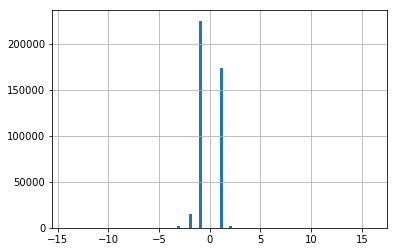

In [24]:
import cPickle as pickle
import numpy as np
a=clip_pred(pickle.load(open("../level1_train/kerasepsl20_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/ridge0_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)

0.705453888624 0.981536228833


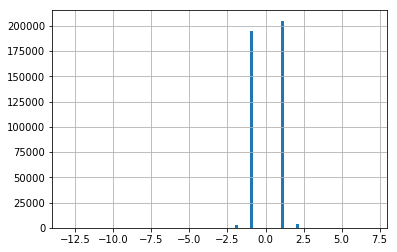

In [25]:
import cPickle as pickle
import numpy as np
a=clip_pred(pickle.load(open("../level1_train/kerasepsl20_test_l1pred.pkl")))
b=clip_pred(pickle.load(open("../level1_train/kerasepsl10_test_l1pred.pkl")))
b=b.loc[a.index]
d=(a-b)
print np.mean(d==0),np.corrcoef(a,b)[0,1]
d[d<>0].hist(bins=100)